In [2]:
import pandas as pd
import numpy as np
from scipy.stats import truncnorm
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor, DMatrix
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import random
from conditionalconformal import CondConf
from matplotlib.patches import Patch
from scipy.spatial import ConvexHull

In [3]:
def phi_fn(feature):
    scalar_values = np.array(feature[:,1])

    # Initialize the indicator matrix
    matrix = np.zeros((len(scalar_values), 3))
    value_z = np.array([3,5,7])

    # Fill in the indicator matrix
    for i, value in enumerate(scalar_values):
        for j in range(0,3):
            if  value == value_z[j]:
                matrix[i, j] = 1

    return matrix

In [4]:
alpha = 0.1
def conformal_predict_z_0(alpha=0.1, m=2500, z_0=3):
    IR = []
    for j in range(1000):
        Z_space = [3, 5, 7]
        N = 1000
        z = np.random.choice(Z_space, N)
        x_sd = 1  
        epsilon_x = np.random.normal(loc=z/10, scale=x_sd, size=N)
        x = np.zeros(N)
        for t in range(1, N):
            x[t] = 0.2 * x[t-1] + np.sqrt(1 - 0.2**2) * epsilon_x[t]
        y = np.exp(x) * z + ((x**2)*np.cos(z))*(truncnorm.rvs(-1, 1, loc=0, scale=1, size=N) )
        
        # Creating data frames
        half_N = int(N/2)
        D_cali = pd.DataFrame({'x': x[:half_N], 'y': y[:half_N], 'z': z[:half_N]})
        D_train = pd.DataFrame({'x': x[half_N:], 'y': y[half_N:], 'z': z[half_N:]})
        # fit a eighth order polynomial
        poly = PolynomialFeatures(8)
        X_poly = poly.fit_transform(D_train[['x', 'z']])
        reg = LinearRegression().fit(X_poly, D_train['y'])
        score_fn = lambda feature,  y : abs(y - reg.predict(poly.transform(pd.DataFrame({'x': feature[:,0], 'z': feature[:,1]}))))
        condCovProgram = CondConf(score_fn, phi_fn, {})
        condCovProgram.setup_problem(D_cali[['x', 'z']].to_numpy(),D_cali['y'].to_numpy())
        
        z_new = np.full(m, z_0)
        epsilon_x_new = np.random.normal(loc=z_new/10, scale=x_sd, size=m)
        x_new = np.zeros(m)
        for t in range(1, m):
            x_new[t] = 0.2 * x_new[t-1] + np.sqrt(1 - 0.2**2) * epsilon_x_new[t]
        y_new = np.exp(x_new) * z_new + ((x_new **2)*np.cos(z_new))*(truncnorm.rvs(-1, 1, loc=0, scale=1, size=m))
        new_data = pd.DataFrame({'x': x_new, 'y': y_new, 'z': z_new})
        
        dtest_new = pd.DataFrame({'x': x_new, 'z': z_new})
        predicted_values_poly_new = reg.predict(poly.transform(dtest_new))
        Xtest = np.array([new_data[['x', 'z']].to_numpy()[11,:]])
        d = condCovProgram.predict(1-alpha, Xtest, lambda x, y : x)
        # Calculate intervals
        hat_t_L = predicted_values_poly_new - d
        hat_t_U = predicted_values_poly_new + d
        IR.append(np.mean((hat_t_L <= new_data['y']) & (new_data['y'] <= hat_t_U) ))
    return IR, d

In [5]:
np.random.seed(1)
IR_7, d_7 = conformal_predict_z_0(alpha=0.1, m=50, z_0=7)
IR_3, d_3 = conformal_predict_z_0(alpha=0.1, m=50, z_0=3)
IR_5, d_5 = conformal_predict_z_0(alpha=0.1, m=50, z_0=5)

IR = [IR_3, IR_5, IR_7]  

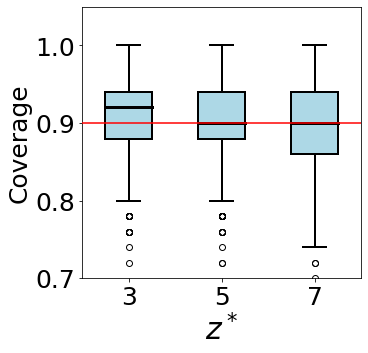

In [6]:
fig = plt.figure(figsize=(5, 5))

alpha = 0.1
plt.boxplot(IR, patch_artist=True, 
            medianprops=dict(color="black", linewidth=3),  
            boxprops=dict(facecolor='lightblue', linewidth=2),  
            whiskerprops=dict(linewidth=2),  
            capprops=dict(linewidth=2),widths=0.5)  

plt.axhline(y=1-alpha, color='red', linestyle='-', label='', linewidth=1.5,zorder=3)
plt.ylim(0.7, 1.05)
plt.xlabel('$z^*$', fontsize=30)
plt.ylabel('Coverage', fontsize=25)
plt.locator_params(axis='y', nbins=5)  
plt.yticks( fontsize=25)
plt.xticks([1, 2, 3], [3, 5, 7], fontsize=25)  
plt.show()


In [7]:
def create_coordinates(v):
    m = len(v)
    coordinates = np.zeros((m, 2))  

    for j in range(m):
        coordinates[j, 0] = (2 * j + 1) / (2 * m) 
        coordinates[j, 1] = (2 * j + 1) * v[j] / (2 * m)  

    return coordinates

def get_slope(x, hull_points, slopes):
    for i in range(len(hull_points) - 1):
        x1, x2 = hull_points[i][0], hull_points[i + 1][0]
        if x1 <= x <= x2:
            if x == x2 and i < len(slopes) - 1:
                return max(slopes[i], slopes[i + 1])
            if x == x1 and i > 0:
                return max(slopes[i - 1], slopes[i])
            return slopes[i]
    return None


def find_last_min_non_negative_index(nums):
    min_non_neg = float('inf')  
    min_index = -1  
    for i, num in enumerate(nums):
        if num >= 0 and num <= min_non_neg:
            min_non_neg = num
            min_index = i

    return min_index


def myerson_reserve(table):
    sorted_bids = np.sort(table['y'])[::-1] 
    new_vector_1 = create_coordinates(sorted_bids)
    new_points = np.array([[0, 0], [1, 0]])
    new_vector_1 = np.concatenate((new_points[0:1], new_vector_1, new_points[1:2]), axis=0)
    points = new_vector_1
    hull = ConvexHull(points)
    hull_points = points[hull.vertices]
    hull_points = hull_points[hull_points[:, 0].argsort()]

    slopes = []
    for i in range(len(hull_points) - 1):
        x1, y1 = hull_points[i]
        x2, y2 = hull_points[i + 1]
        slope = (y2 - y1) / (x2 - x1)
        slopes.append(slope)

    point_slopes = []
    for point in points:
        x = point[0]
        slope = get_slope(x, hull_points, slopes)
        point_slopes.append(slope)
        
    index_reserve = find_last_min_non_negative_index(point_slopes[1:-1])
    return sorted_bids[index_reserve]


In [8]:
alpha = 0.1
def conformal_predict( m=1000, z_0=3, N=1000):
    # Data generation
    Z_space = [3, 5, 7]
    z = np.random.choice(Z_space, N)
    x_sd = 1  
    
    epsilon_x = np.random.normal(loc=z/10, scale=x_sd, size=N)
    x = np.zeros(N)
    for t in range(1, N):
        x[t] = 0.2 * x[t-1] + np.sqrt(1 - 0.2**2) * epsilon_x[t]
    y = np.exp(x) * z + ((x**2)*np.cos(z))*(truncnorm.rvs(-1, 1, loc=0, scale=1, size=N) )
    ############################################## The Empirical Myerson Auction
    D_myerson = pd.DataFrame({'x': x, 'y': y, 'z': z})
    df_myerson =  D_myerson[D_myerson['z'] == z_0]
    myerson_reserve_price = myerson_reserve(df_myerson)
    ##############################################
    # Creating data frames
    half_N = int(N/2)
    D_cali = pd.DataFrame({'x': x[:half_N], 'y': y[:half_N], 'z': z[:half_N]})
    D_train = pd.DataFrame({'x': x[half_N:], 'y': y[half_N:], 'z': z[half_N:]})
    # fit a eighth order polynomial
    poly = PolynomialFeatures(8)
    X_poly = poly.fit_transform(D_train[['x', 'z']])
    reg = LinearRegression().fit(X_poly, D_train['y'])    
    score_fn = lambda feature,  y : abs(y - reg.predict(poly.transform(pd.DataFrame({'x': feature[:,0], 'z': feature[:,1]}))))
    condCovProgram = CondConf(score_fn, phi_fn, {})
    condCovProgram.setup_problem(D_cali[['x', 'z']].to_numpy(),D_cali['y'].to_numpy())

    z_new = np.full(m, z_0)
    epsilon_x_new = np.random.normal(loc=z_new/10, scale=x_sd, size=m)
    x_new = np.zeros(m)
    for t in range(1, m):
        x_new[t] = 0.2 * x_new[t-1] + np.sqrt(1 - 0.2**2) * epsilon_x_new[t]
    y_new = np.exp(x_new) * z_new + ((x_new **2)*np.cos(z_new))*(truncnorm.rvs(-1, 1, loc=0, scale=1, size=m))
    new_data = pd.DataFrame({'x': x_new, 'y': y_new, 'z': z_new})
    dtest_new = pd.DataFrame(new_data[['x', 'z']])
    predicted_values_poly_new = reg.predict(poly.transform(dtest_new))
    Xtest = np.array([new_data[['x', 'z']].to_numpy()[3,:]])
    d = condCovProgram.predict(1-alpha, Xtest, lambda x, y : x)
        
    reserve_price = predicted_values_poly_new - d
    virtual_value = new_data['y'] * (new_data['y'] > reserve_price)
    
    # Find the index(es) of the maximum virtual value
    max_virtual_value_indexes = np.where(virtual_value == np.max(virtual_value))[0]

    winner = None
    if len(max_virtual_value_indexes) > 1:
    # Check the reserve price for the max virtual value indexes
        max_reserve_price_indexes = np.where(reserve_price[max_virtual_value_indexes] == np.max(reserve_price[max_virtual_value_indexes]))[0]

        if len(max_reserve_price_indexes) > 1:
        # If multiple maximums, choose one at random
            winner = np.random.choice(max_virtual_value_indexes[max_reserve_price_indexes])
        else:
        # If only one maximum
            winner = max_virtual_value_indexes[max_reserve_price_indexes[0]]
    else:
    # If only one maximum virtual value
        winner = max_virtual_value_indexes[0]
    

    sorted_virtual_value = np.sort(virtual_value)[::-1]
    payment = max(0, sorted_virtual_value[1], reserve_price[winner])
    max_welfare = np.max(new_data['y'])
    sb_value = np.sort(new_data['y'])[::-1][1] if len(np.sort(new_data['y'])[::-1]) >= 2 else 0
    
    myerson_value = np.maximum(np.sort(new_data['y'])[::-1][1], myerson_reserve_price) if np.sort(new_data['y'])[::-1][0] >= myerson_reserve_price else 0

    return payment, myerson_value, myerson_reserve_price, sb_value, max_welfare

In [17]:
np.random.seed(1)
N_values = [200, 600, 1000, 1400, 1800]
z_values = [3, 5, 7]
num_runs = 1000
m = 50

# Initialize a more detailed results dictionary for each z_0 value
results = {z: [] for z in z_values}

# Simulation for each z value
for z_0 in z_values:
    np.random.seed(1)
    for N in N_values:
        payments, myerson_values, myerson_reserve_prices, sb_values, max_welfares = [], [], [], [], []
        for _ in range(num_runs):
            payment, myerson_value, myerson_reserve_price, sb_value, max_welfare = conformal_predict(m, z_0, N)
            payments.append(payment)
            myerson_values.append(myerson_value)
            myerson_reserve_prices.append(myerson_reserve_price)
            sb_values.append(sb_value)
            max_welfares.append(max_welfare)
        results[z_0].append({
            "N": N,
            "payments": payments,
            "sb_values": sb_values,
            "max_welfares": max_welfares,
            "myerson_values":  myerson_values,
            "myerson_reserve_prices": myerson_reserve_prices
        })


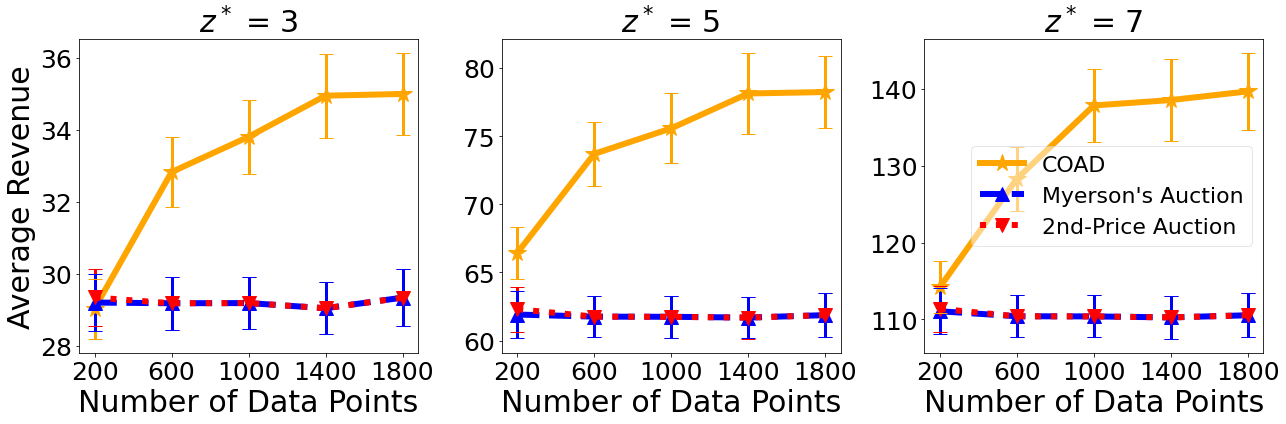

In [30]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  

for i, z_0 in enumerate(z_values):
    payments_means = []
    payments_ses = []
    sb_values_means = []
    sb_values_ses = []
    max_welfares_means = []
    max_welfares_ses = []
    myerson_values_means = []
    myerson_values_ses = []

    for entry in results[z_0]:
        payments_means.append(np.mean(entry['payments']))
        payments_ses.append(1.96 * np.std(entry['payments']) / np.sqrt(len(entry['payments'])))
        sb_values_means.append(np.mean(entry['sb_values']))
        sb_values_ses.append(1.96 * np.std(entry['sb_values']) / np.sqrt(len(entry['sb_values'])))
        max_welfares_means.append(np.mean(entry['max_welfares']))
        max_welfares_ses.append(1.96 * np.std(entry['max_welfares']) / np.sqrt(len(entry['max_welfares'])))
        myerson_values_means.append(np.mean(entry['myerson_values']))
        myerson_values_ses.append(1.96 * np.std(entry['myerson_values']) / np.sqrt(len(entry['myerson_values'])))

   
    axs[i].plot(N_values, payments_means, label="COAD", color='orange', linestyle='-', marker='*', linewidth=6, markersize=18)
    axs[i].plot(N_values, myerson_values_means, label="Myerson's Auction", color='blue', linestyle='--', marker='^', linewidth=6, markersize=14)
    axs[i].plot(N_values, sb_values_means, label="2nd-Price Auction", color='red', linestyle=':', marker='v', linewidth=6, markersize=14)
    axs[i].errorbar(N_values, payments_means, yerr=payments_ses, fmt='none', ecolor='orange', capsize=7, elinewidth=3)
    axs[i].errorbar(N_values, sb_values_means, yerr=sb_values_ses, fmt='none', ecolor='red', capsize=7, elinewidth=3)
    axs[i].errorbar(N_values, myerson_values_means, yerr=myerson_values_ses, fmt='none', ecolor='blue', capsize=7, elinewidth=3)

    axs[i].set_xlabel("Number of Data Points", fontsize=30)
    axs[i].set_ylabel("Average Revenue" if i == 0 else "", fontsize=30)  
    axs[i].set_title(f"$z^*$ = {z_0}", fontsize=30)
    axs[i].tick_params(axis='both', labelsize=25)
    axs[i].set_xticks([200, 600, 1000, 1400, 1800])  
    if i == 2:
        axs[i].legend(fontsize=22, facecolor='white', framealpha=0.5)

plt.tight_layout()
plt.show()

In [29]:

np.random.seed(1)

m_values = list(range(50, 401, 50))
N = 5000
num_runs = 1000
z_0_values = [3, 5, 7]  # Different z values for each plot
# Initialize a more detailed results dictionary for each z_0 value
results_m = {z: [] for z in z_values}

for i, z_0 in enumerate(z_0_values):
    np.random.seed(0)
    for m in m_values:
        payments, myerson_values, myerson_reserve_prices, sb_values, max_welfares = [], [], [], [], []
        for _ in range(num_runs):
            payment, myerson_value, myerson_reserve_price, sb_value, max_welfare = conformal_predict(m, z_0, N)
            payments.append(payment)
            myerson_values.append(myerson_value)
            myerson_reserve_prices.append(myerson_reserve_price)
            sb_values.append(sb_value)
            max_welfares.append(max_welfare)
        results_m[z_0].append({
            "m": m,
            "payments": payments,
            "sb_values": sb_values,
            "max_welfares": max_welfares,
            "myerson_values":  myerson_values,
            "myerson_reserve_prices": myerson_reserve_prices
        })
 

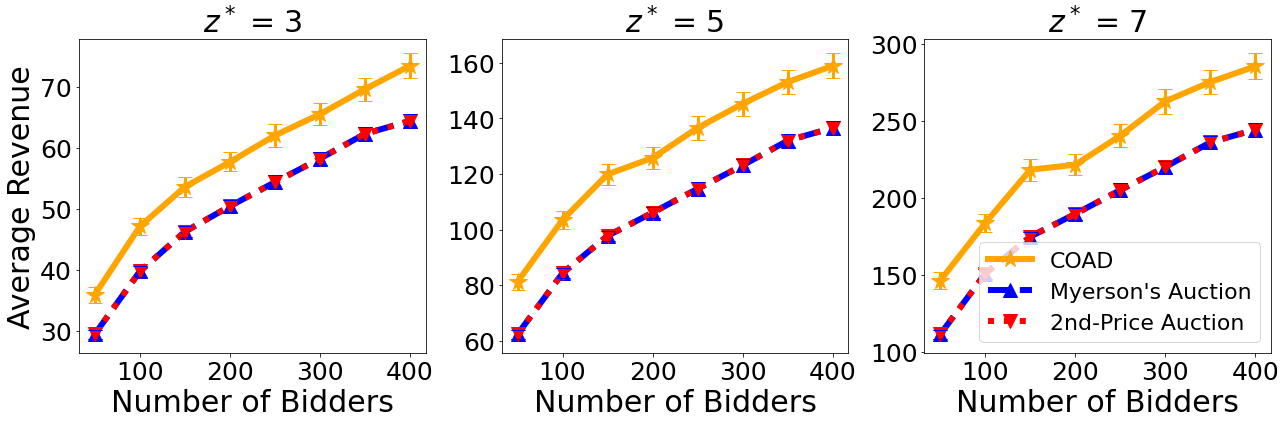

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i, z_0 in enumerate(z_0_values):
    m_values = [entry['m'] for entry in results_m[z_0]]
    payments_means = [np.mean(entry['payments']) for entry in results_m[z_0]]
    payments_ses = [1.96*np.std(entry['payments']) / np.sqrt(len(entry['payments'])) for entry in results_m[z_0]]
    sb_values_means = [np.mean(entry['sb_values']) for entry in results_m[z_0]]
    sb_values_ses = [1.96*np.std(entry['sb_values']) / np.sqrt(len(entry['sb_values'])) for entry in results_m[z_0]]
    max_welfares_means = [np.mean(entry['max_welfares']) for entry in results_m[z_0]]
    max_welfares_ses = [1.96*np.std(entry['max_welfares']) / np.sqrt(len(entry['max_welfares'])) for entry in results_m[z_0]]
    myerson_values_means = [np.mean(entry['myerson_values']) for entry in results_m[z_0]]
    myerson_values_ses = [1.96 * np.std(entry['myerson_values']) / np.sqrt(len(entry['myerson_values'])) for entry in results_m[z_0]]
    
    axs[i].plot(m_values, payments_means, label="COAD", color='orange', linestyle='-', marker='*', linewidth=6, markersize=18)
    axs[i].plot(m_values, myerson_values_means, label="Myerson's Auction", color='blue', linestyle='--', marker='^', linewidth=6, markersize=14)
    axs[i].plot(m_values, sb_values_means, label="2nd-Price Auction", color='red', linestyle=':', marker='v', linewidth=6, markersize=14)
    axs[i].errorbar(m_values, payments_means, yerr=payments_ses, fmt='none', ecolor='orange', capsize=7, elinewidth=3)
    axs[i].errorbar(m_values, sb_values_means, yerr=sb_values_ses, fmt='none', ecolor='red', capsize=7, elinewidth=3)
    axs[i].errorbar(m_values, myerson_values_means, yerr=myerson_values_ses, fmt='none', ecolor='blue', capsize=7, elinewidth=3)
        
    axs[i].set_xlabel("Number of Bidders", fontsize=30)
    axs[i].tick_params(axis='both', which='major', labelsize=25)
    axs[i].locator_params(axis='y', nbins=7)
    axs[i].set_title(f"$z^*$ = {z_0}", fontsize=30)
    if i == 2:
        axs[i].legend(fontsize=22, loc='lower right')
axs[0].set_ylabel("Average Revenue", fontsize=30)
plt.tight_layout()
plt.show()